<a href="https://colab.research.google.com/github/tanisha1112/ECE_792_Assignments/blob/main/ECE_792_hw02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torchvision import transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import sklearn
from torch.utils.data import DataLoader
from torch import optim
from torch.autograd import Variable

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:

transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

mnist_trainset = datasets.MNIST(root='./DATA', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./DATA', train=False, download=True, transform=transform)

100%|██████████| 9912422/9912422 [00:00<00:00, 67957154.21it/s]


Extracting ./DATA/MNIST/raw/train-images-idx3-ubyte.gz to ./DATA/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 33196956.38it/s]


Extracting ./DATA/MNIST/raw/train-labels-idx1-ubyte.gz to ./DATA/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 17879714.37it/s]


Extracting ./DATA/MNIST/raw/t10k-images-idx3-ubyte.gz to ./DATA/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5275693.37it/s]


Extracting ./DATA/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./DATA/MNIST/raw



In [ ]:
train_batchsize = 100
test_batchsize = 100
train_dataloader = torch.utils.data.DataLoader(mnist_trainset, batch_size=train_batchsize, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(mnist_testset, batch_size=test_batchsize, shuffle=True)

print("Training dataset size: ", len(mnist_trainset))
print("Testing dataset size: ", len(mnist_testset))

Training dataset size:  60000
Testing dataset size:  10000


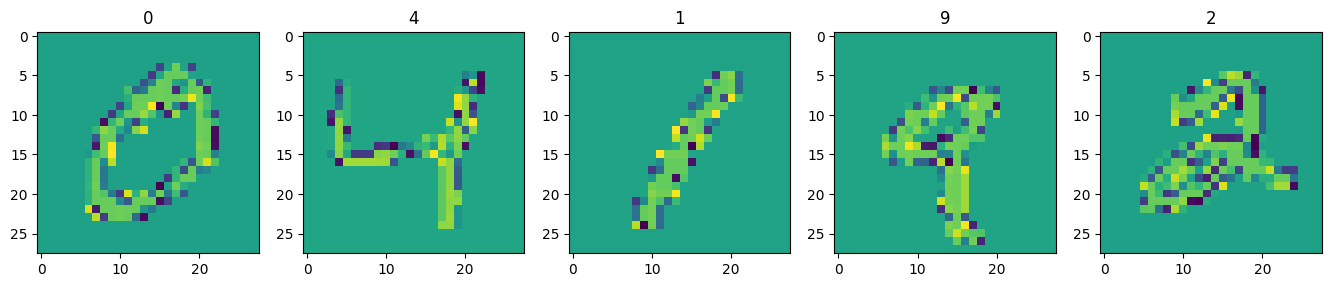

In [ ]:
# visualize data
fig=plt.figure(figsize=(20, 10))
for i in range(1, 6):
    img = transforms.ToPILImage()(mnist_trainset[i][0])
    fig.add_subplot(1, 6, i)
    plt.title(mnist_trainset[i][1])
    plt.imshow(img)
plt.show()

In [ ]:
img, label=mnist_trainset[1]
print(img.shape,label)


torch.Size([1, 28, 28]) 0


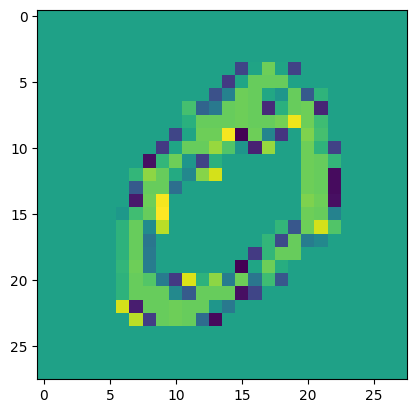

In [ ]:
img = transforms.ToPILImage(mode='L')(img)
plt.imshow(img)


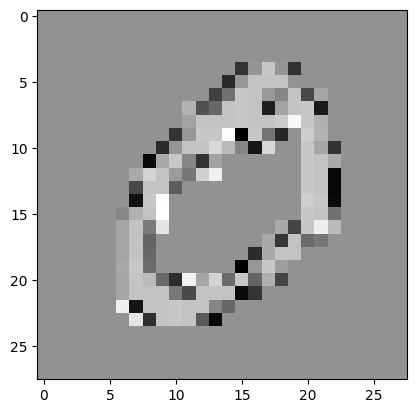

In [ ]:
arr = np.asarray(img)
plt.imshow(arr, cmap ="gray")

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        #6 (5×5 size) convolutional filters with stride 1x1 and 2x2 padding.
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=6,
                kernel_size=5,
                stride=1,
                padding=2,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, return_indices=True),
        )
        # self.conv1 = nn.Conv2d(in_channels=1,out_channels=6,kernel_size=5,stride=1,padding=2)

        # 16 (5×5 size) convolutional filters with stride 1x1 and no padding.
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=6,
                out_channels=16,
                kernel_size=5,
                stride=1,
                padding=0,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, return_indices=True),
        )
        # self.conv2 = nn.Conv2d(in_channels=6,out_channels=16,kernel_size=5,stride=1,padding=0)

        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        #28*28*1
        x,indices= self.conv1(x)         #28 * 28* 6
        #ReLU activation
        # x = F.relu(x)
        #Max Pooling layer (2×2 size and 2x2 stride)
        # x = F.max_pool2d(x, kernel_size=2, stride=2, padding=0)       #14*14*6

        x,indices = self.conv2(x)               #10 *10* 16
        #ReLU activation
        # x = F.relu(x)
        # x = F.max_pool2d(x ,kernel_size= 2,stride=2)            #5*5*16
        #Flatten
        x = x.reshape(-1, 5*5*16)

        #relu after Fully connected linear layer
        x = self.fc1(x)
        x = F.relu(x)
        #relu
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        return x


In [ ]:
cnn = CNN()
cnn

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
from torchsummary import summary
summary(cnn, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
              ReLU-2            [-1, 6, 28, 28]               0
         MaxPool2d-3  [[-1, 6, 14, 14], [-1, 6, 14, 14]]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
              ReLU-5           [-1, 16, 10, 10]               0
         MaxPool2d-6  [[-1, 16, 5, 5], [-1, 16, 5, 5]]               0
            Linear-7                  [-1, 120]          48,120
            Linear-8                   [-1, 84]          10,164
            Linear-9                   [-1, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 11.67
Params size (MB): 0.24
Estimated Total Size (MB): 11.91
---------------------------

In [ ]:
optimizer = optim.Adam(cnn.parameters(), lr = 0.01)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)

In [ ]:
num_epochs = 10
len(train_dataloader)


600

In [ ]:
def accuracy(predictions, labels):
    classes = torch.argmax(predictions, dim=1)
    return torch.mean((classes == labels).float())

acc_train = []
loss_train = []
cnn.train()
for epoch in range(1,6):
    for batch in train_dataloader:
        inputs, labels = batch
        optimizer.zero_grad()
        out = cnn(inputs.to(device))       #forward pass
        loss = F.nll_loss(out, labels)
        loss.backward()                #backward pass
        optimizer.step()
    training_accuracy = accuracy(out, labels.to(device))
    acc_train.append(training_accuracy.item())
    loss_train.append(loss.item())

    # Report
    print(f"Epoch:{epoch} Loss:{loss:.2f} Accuracy:{training_accuracy*100}")

print('Training process has finished!')

Epoch:1 Loss:0.07 Accuracy:97.0
Epoch:2 Loss:0.01 Accuracy:100.0
Epoch:3 Loss:0.04 Accuracy:99.0
Epoch:4 Loss:0.06 Accuracy:99.0
Epoch:5 Loss:0.05 Accuracy:99.0
Training process has finished!


In [ ]:
acc_test = []
loss_test = []
cnn.eval()
for epoch in range(1,6):
    for batch in test_dataloader:
        inputs, labels = batch
        optimizer.zero_grad()
        out = cnn(inputs.to(device))
        loss = F.nll_loss(out, labels)
        loss.backward()
        optimizer.step()
    test_accuracy = accuracy(out, labels.to(device))
    acc_test.append(test_accuracy.item())
    loss_test.append(loss.item())

    # Report
    print(f"Epoch:{epoch} Loss:{loss:.2f} Accuracy:{test_accuracy*100}")

print('Test process has finished!')

Epoch:1 Loss:0.04 Accuracy:98.0
Epoch:2 Loss:0.20 Accuracy:97.0
Epoch:3 Loss:0.06 Accuracy:98.0
Epoch:4 Loss:0.01 Accuracy:100.0
Epoch:5 Loss:0.07 Accuracy:99.0
Test process has finished!


In [ ]:
sample = next(iter(test_dataloader))
imgs, lbls = sample

In [ ]:
actual_number = lbls[:10].numpy()
actual_number

array([5, 7, 7, 3, 7, 1, 1, 2, 1, 4])

In [ ]:
test_output = cnn(imgs[:10])
pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
print(f'Prediction number: {pred_y}')
print(f'Actual number: {actual_number}')

Prediction number: [5 7 7 3 7 1 1 2 1 4]
Actual number: [5 7 7 3 7 1 1 2 1 4]


##Deconv

In [ ]:
img,label =mnist_testset[1]
label

2

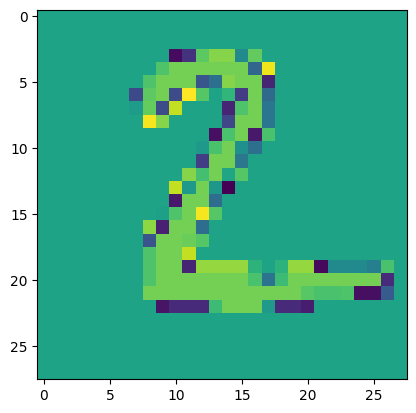

In [ ]:
img_PIL = transforms.ToPILImage()(img)
plt.imshow(img_PIL)

In [ ]:
conv1 = cnn.conv1
conv1

Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [ ]:
x = img.unsqueeze(1)
x, indices= conv1(x)
x.shape

torch.Size([1, 6, 14, 14])

In [ ]:
selected_activation = x[0,5]
selected_activation.shape

torch.Size([14, 14])

In [ ]:
empty_tensor = torch.zeros(1, 6, 14, 14)
empty_tensor.shape
activation = []

In [ ]:
empty_tensor[:,5, :, :] = selected_activation
activation.append(empty_tensor)

In [ ]:
activation[0]

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          

In [ ]:
unpool = nn.MaxUnpool2d(2, stride=2)
activation[0] = unpool(activation[0], indices)

In [ ]:
activation[0] = F.relu(activation[0])
activation[0].shape

torch.Size([1, 6, 28, 28])

In [ ]:
conv_weight = conv1[0].weight


In [ ]:
conv_weight.shape

torch.Size([6, 1, 5, 5])

In [ ]:
weight_transposed =torch.permute(conv_weight,(1,0,3,2))
weight_transposed.shape

torch.Size([1, 6, 5, 5])

In [ ]:
result = F.conv2d(activation[0], weight_transposed, stride=1, padding=9)
result.shape

torch.Size([1, 1, 42, 42])

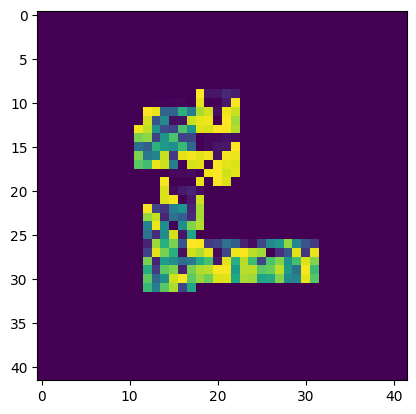

In [ ]:
deconvimg = transforms.ToPILImage()(result[0])
plt.imshow(deconvimg)

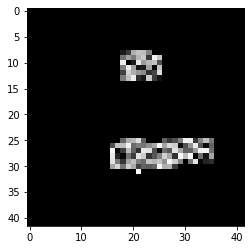

In [ ]:
arr = np.asarray(deconvimg)
plt.imshow(arr, cmap ="gray")

In [ ]:
activations = []
deconvimg_list = []

In [ ]:
activation_conv1 = 6


In [ ]:
def deconv1(img):
  for i in range(0,activation_conv1):
      x = img.unsqueeze(1)
      conv1 = cnn.conv1
      x, indices= conv1(x)
      selected_activation = x[0,i]
      empty_tensor = torch.zeros(1, activation_conv1, 14, 14)
      empty_tensor[:,i, :, :] = selected_activation
      activations.append(empty_tensor)
      unpool = nn.MaxUnpool2d(2, stride=2)
      activations[i] = unpool(activations[i], indices)
      activations[i] = F.relu(activations[i])
      conv_weight = conv1[0].weight
      weight_transposed =torch.permute(conv_weight,(1,0,3,2))
      result = F.conv2d(activations[i], weight_transposed, stride=1, padding=9)
      deconvimg_list.append(result)
  return deconvimg_list

In [ ]:
#### 0
img,label =mnist_testset[10]
label

0

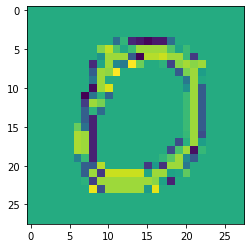

In [ ]:
img_PIL = transforms.ToPILImage()(img)
plt.imshow(img_PIL)

In [ ]:
deconvimg_list = deconv1(img)
deconvimg_list[0].shape

torch.Size([1, 1, 42, 42])

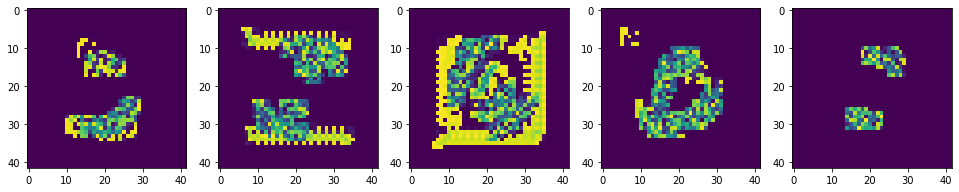

In [ ]:
# visualize data
fig=plt.figure(figsize=(20, 10))
for i in range(1, activation_conv1):
    img = transforms.ToPILImage(mode='L')(deconvimg_list[i][0])
    fig.add_subplot(1, activation_conv1, i)
    plt.imshow(img)
plt.show()


In [ ]:
def deconv2(img):
  for i in range(0,activation_conv2):
      x = img.unsqueeze(1)
      conv1 = cnn.conv1
      x, indices= conv1(x)
      conv2 = cnn.conv2
      x, indices= conv2(x)
      selected_activation = x[0,i]
      empty_tensor = torch.zeros(1, activation_conv2, 5, 5)
      empty_tensor[:,i, :, :] = selected_activation
      activations_2.append(empty_tensor)
      unpool = nn.MaxUnpool2d(2, stride=2)
      activations_2[i] = unpool(activations_2[i], indices)
      activations_2[i] = F.relu(activations_2[i])
      conv_weight = conv2[0].weight
      weight_transposed =torch.permute(conv_weight,(1,0,3,2))
      result = F.conv2d(activations_2[i], weight_transposed, stride=1, padding=4)

      print(result.shape)
      deconvimg_list_2.append(result)
  return deconvimg_list_2

In [ ]:
activations_2 = []
deconvimg_list_2 = []
activation_conv2 = 16

In [ ]:
img,label =mnist_testset[10]
label

0

In [ ]:
deconvimg_list_2 = deconv2(img)

torch.Size([1, 6, 14, 14])
torch.Size([1, 6, 14, 14])
torch.Size([1, 6, 14, 14])
torch.Size([1, 6, 14, 14])
torch.Size([1, 6, 14, 14])
torch.Size([1, 6, 14, 14])
torch.Size([1, 6, 14, 14])
torch.Size([1, 6, 14, 14])
torch.Size([1, 6, 14, 14])
torch.Size([1, 6, 14, 14])
torch.Size([1, 6, 14, 14])
torch.Size([1, 6, 14, 14])
torch.Size([1, 6, 14, 14])
torch.Size([1, 6, 14, 14])
torch.Size([1, 6, 14, 14])
torch.Size([1, 6, 14, 14])


In [ ]:
deconvimg_list_2[0].shape

torch.Size([1, 6, 14, 14])

In [ ]:
# visualize data
fig=plt.figure(figsize=(20, 10))
for i in range(1, activation_conv2):
    img = transforms.ToPILImage(mode='L')(deconvimg_list_2[i][0])
    fig.add_subplot(1, activation_conv2, i)
    plt.imshow(img)
plt.show()